### 원 모델에 대한 시도별 예측

In [1]:
import pandas as pd
import numpy as np
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
import os
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

In [2]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

In [3]:
# 나눔 폰트 경로 설정
# dir = '/data1/E382/hwchoi/00.data/00.preprocessing'
dir='C:/Windows/Fonts'
font_path = os.path.join(dir, 'NANUMGOTHIC.TTF')

# 폰트 속성 설정
fontprop = fm.FontProperties(fname=font_path, size=10)


# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)

# Matplotlib 폰트 캐시 파일 삭제 (필요시 사용)
cache_dir = os.path.expanduser('~/.cache/matplotlib')
font_cache_path = os.path.join(cache_dir, 'fontlist-v330.json')
if os.path.exists(font_cache_path):
    os.remove(font_cache_path)

# 폰트를 matplotlib에 설정
plt.rc('font', family=fontprop.get_name())

###  MODELING

### RandomForest, XGBoost 데이터 셋 재정리

In [4]:
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0731.csv'
df=pd.read_csv(path)
df.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,...,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,...,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


In [5]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [6]:
features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm', 'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man', 'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

48


In [7]:
# 기본 모델(RandomForest, XGBoost)
# 학습 데이터와 테스트 데이터로 분할
# 데이터 스케일링
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=11, shuffle=True)

### RandomForest Modeling

In [8]:
# RandomForestRegressor 모델 정의 및 학습
rf_model = RandomForestRegressor(random_state=11)
rf_model.fit(X_train, y_train)

# 예측
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# 평가
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
r2_train_rf = r2_score(y_train, y_pred_train_rf)

mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print("Random Forest Regressor:")
print(f'Training MAE: {mae_train_rf}')
print(f'Training RMSE: {rmse_train_rf}')
print(f'Training R2: {r2_train_rf}')
print()
print(f'Test MAE: {mae_test_rf}')
print(f'Test RMSE: {rmse_test_rf}')
print(f'Test R2: {r2_test_rf}')

Random Forest Regressor:
Training MAE: 0.19720876585928487
Training RMSE: 0.49094530977837764
Training R2: 0.9560524360322468

Test MAE: 0.5353940792003076
Test RMSE: 1.2379338120552341
Test R2: 0.7473551937048468


### XGBoost Modeling

In [9]:
# XGBoost 모델 정의 및 학습
xgb_model = XGBRegressor(random_state=11)
xgb_model.fit(X_train, y_train)

# 예측
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

# 평가
mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)

mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

print("XGBoost Regressor:")
print(f'Training MAE: {mae_train_xgb}')
print(f'Training RMSE: {rmse_train_xgb}')
print(f'Training R2: {r2_train_xgb}')
print()
print(f'Test MAE: {mae_test_xgb}')
print(f'Test RMSE: {rmse_test_xgb}')
print(f'Test R2: {r2_test_xgb}')

XGBoost Regressor:
Training MAE: 0.2538571333627487
Training RMSE: 0.4731666935762716
Training R2: 0.959177752647343

Test MAE: 0.5166442152973487
Test RMSE: 1.2281980105213979
Test R2: 0.7513134464709706


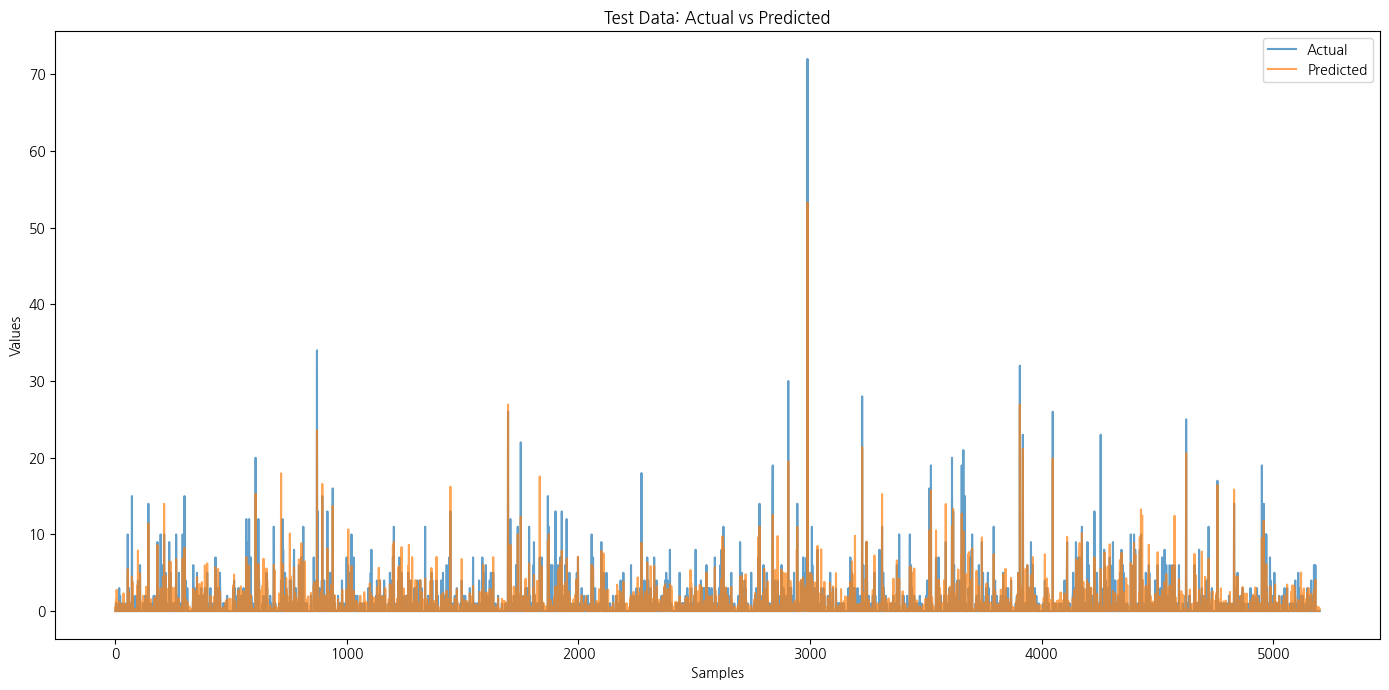

In [10]:
# 실제값과 예측값을 비교하는 라인차트 시각화
plt.figure(figsize=(14, 7))

# Test 데이터에 대한 라인차트
plt.plot(y_test.reset_index(drop=True), label='Actual', alpha=0.7)
plt.plot(y_pred_test_rf, label='Predicted', alpha=0.7)
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

### SIDO별 모델링 (CASE1)

In [4]:
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0731.csv'
df=pd.read_csv(path)
df.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,...,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,...,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


In [5]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [6]:
features = ['weekend_yn', 'sido_cd', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
            'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
            'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
            'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
            'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target = 'patientsCnt'

In [7]:
# 시도별로 테스트 데이터를 0.2 비율로 가져오고 나머지 데이터는 학습 데이터로 사용
test_data_list = []
train_data_list = []
sido_cds = df['sido_cd'].unique()

for sido_cd in sido_cds:
    df_sido = df[df['sido_cd'] == sido_cd]
    df_train, df_test = train_test_split(df_sido, test_size=0.2, random_state=11, shuffle=True)
    test_data_list.append(df_test)
    train_data_list.append(df_train)

# 테스트 데이터와 학습 데이터 합치기
test_data = pd.concat(test_data_list)
train_data = pd.concat(train_data_list)

# 특징과 목표 변수 분리
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# 데이터 스케일링
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# RandomForest 모델 정의 및 학습
rf_model = RandomForestRegressor(random_state=11)
rf_model.fit(X_train, y_train)

# XGBoost 모델 정의 및 학습
xgb_model = XGBRegressor(random_state=11)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=11, ...)

In [9]:
dt_map = {'39': '제주특별자치도', '32': '강원특별자치도', '25': '대전광역시','21': '부산광역시',
    '24': '광주광역시','26': '울산광역시', '38': '경상남도','23': '인천광역시',
    '31': '경기도','33': '충청북도', '22': '대구광역시','35': '전북특별자치도',
    '37': '경상북도','29': '세종특별자치시','36': '전라남도','11': '서울특별시','34': '충청남도'
}

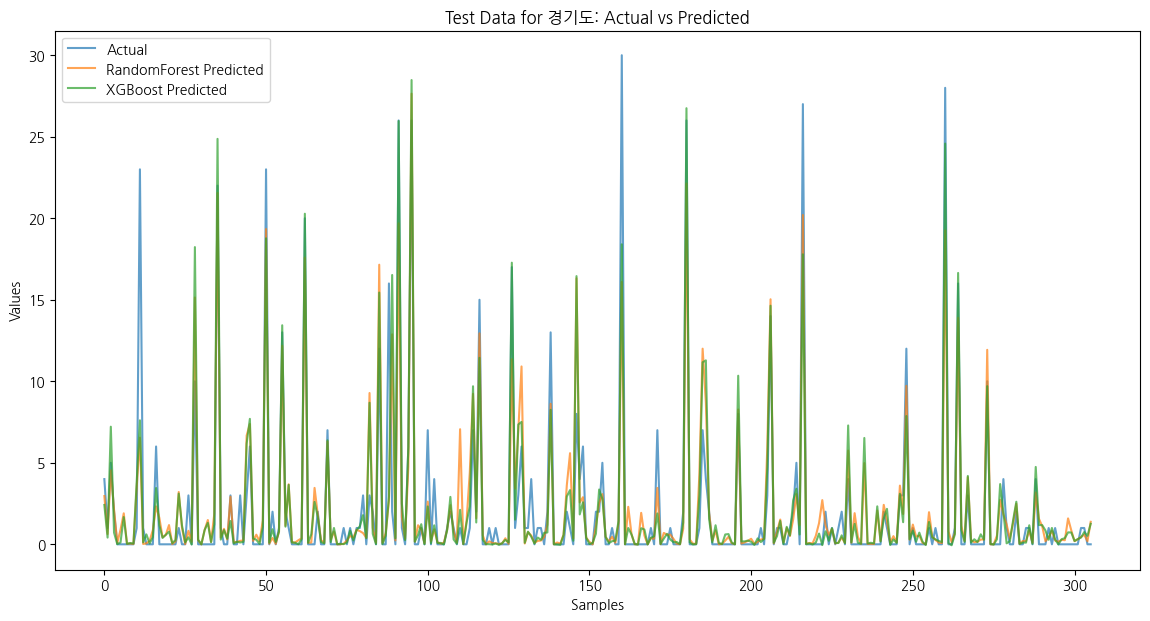

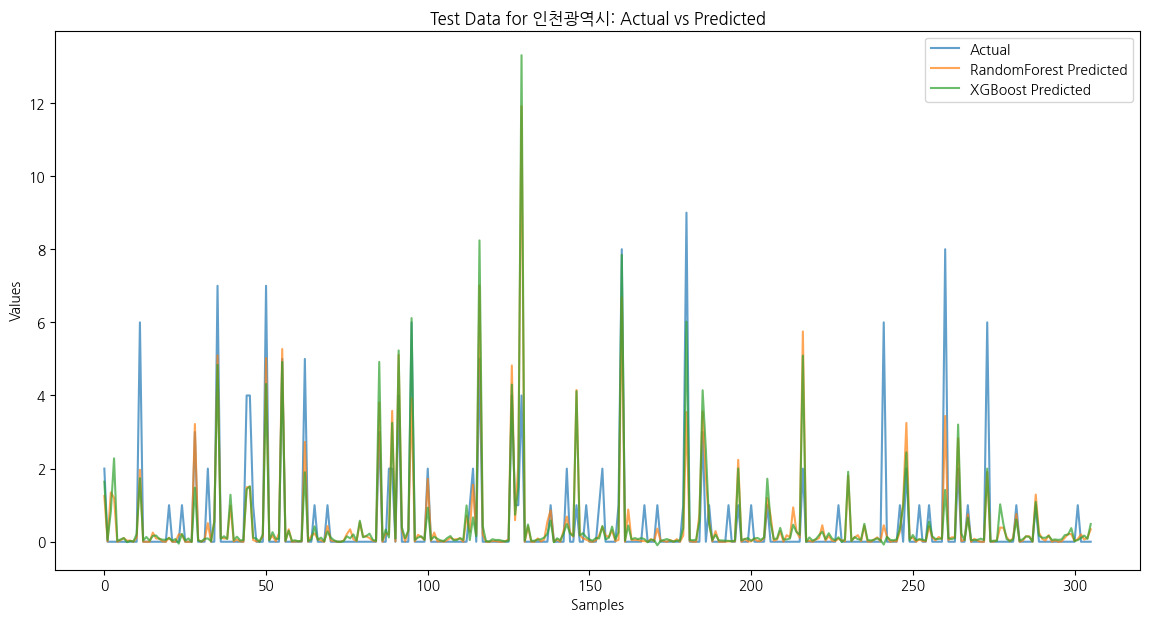

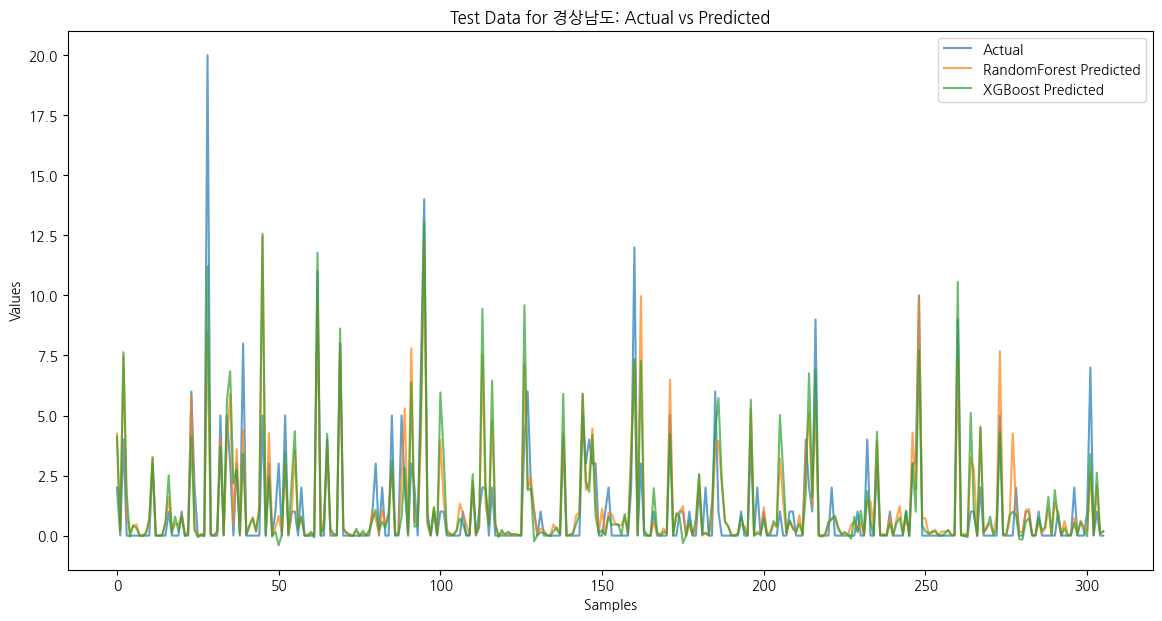

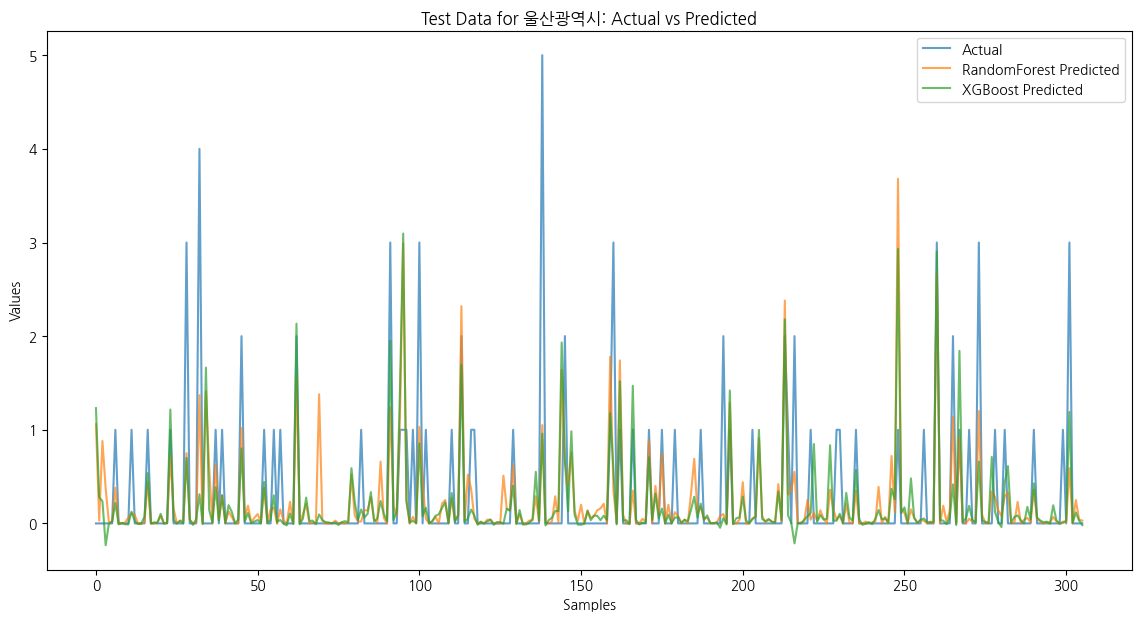

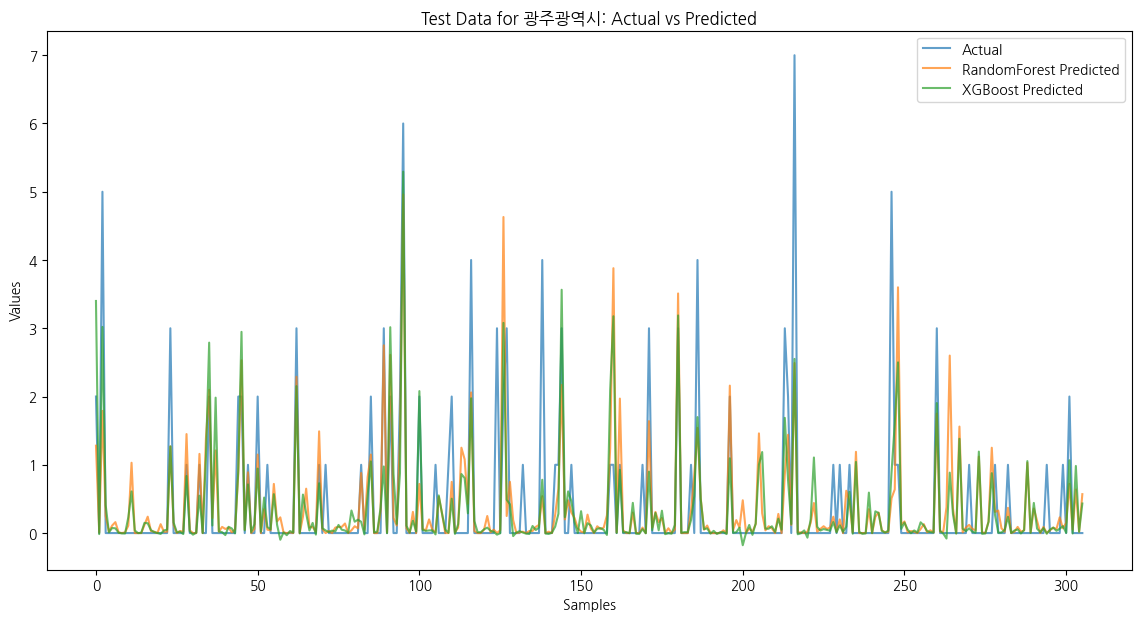

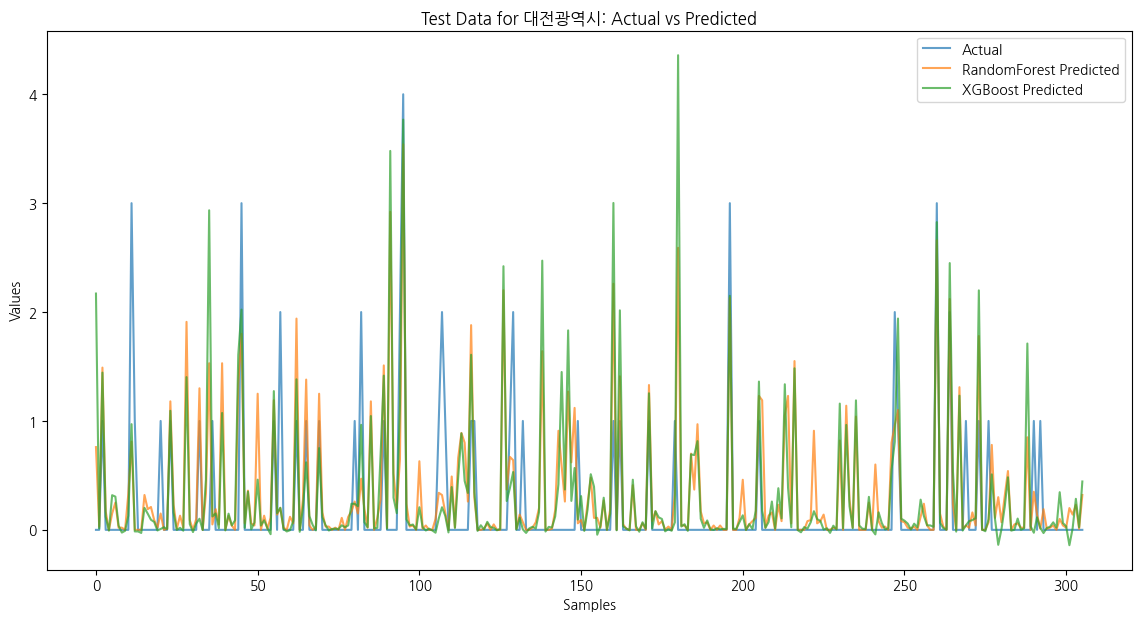

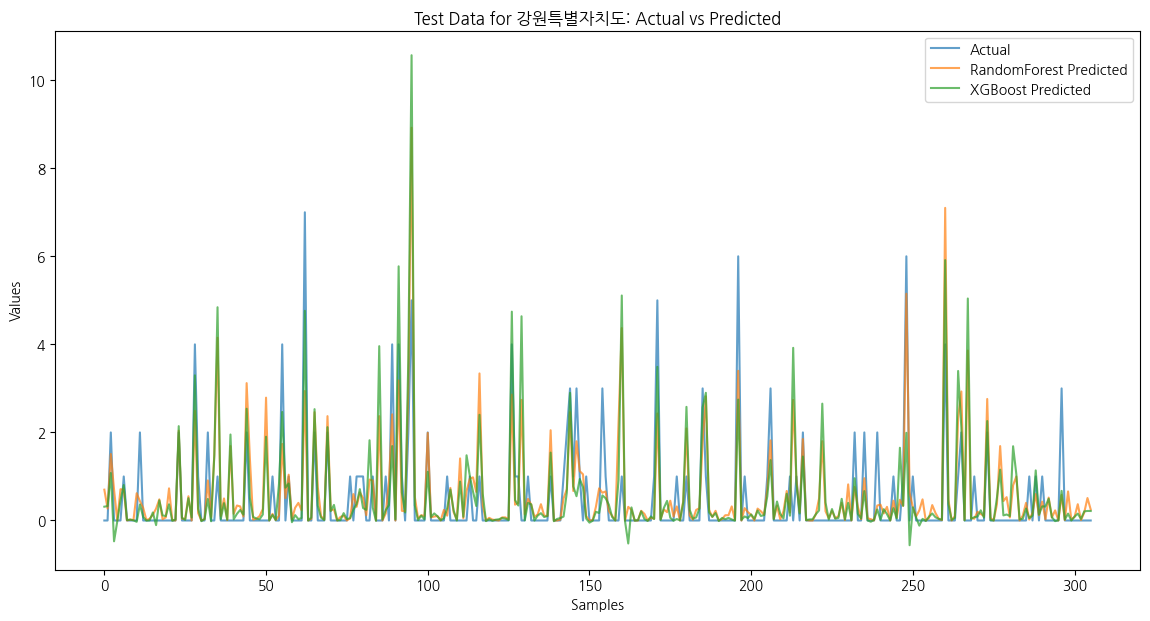

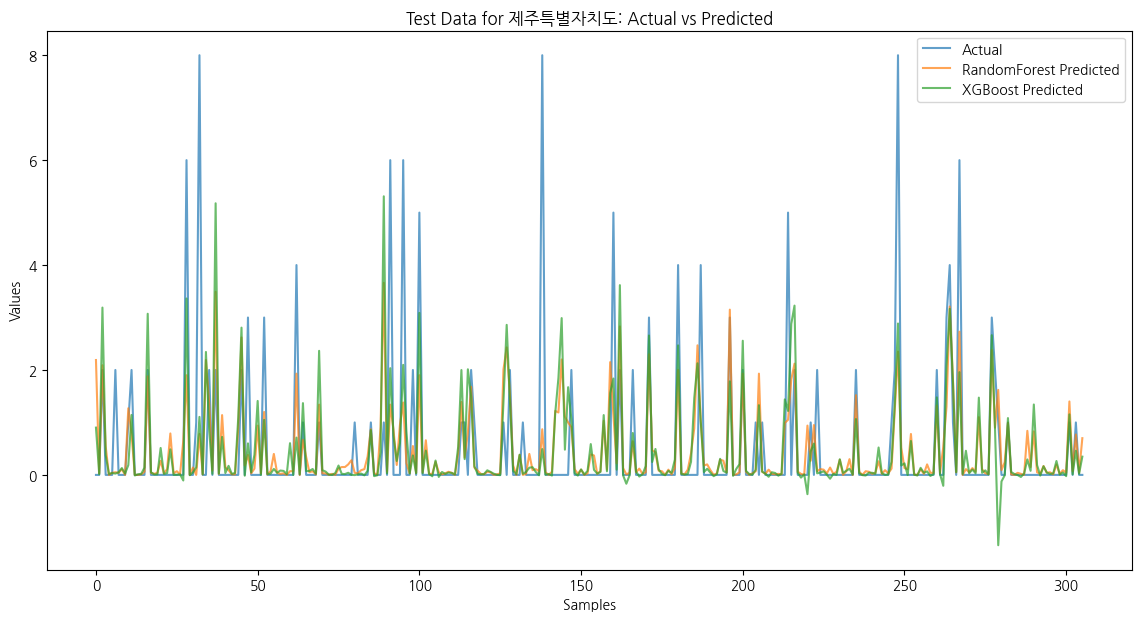

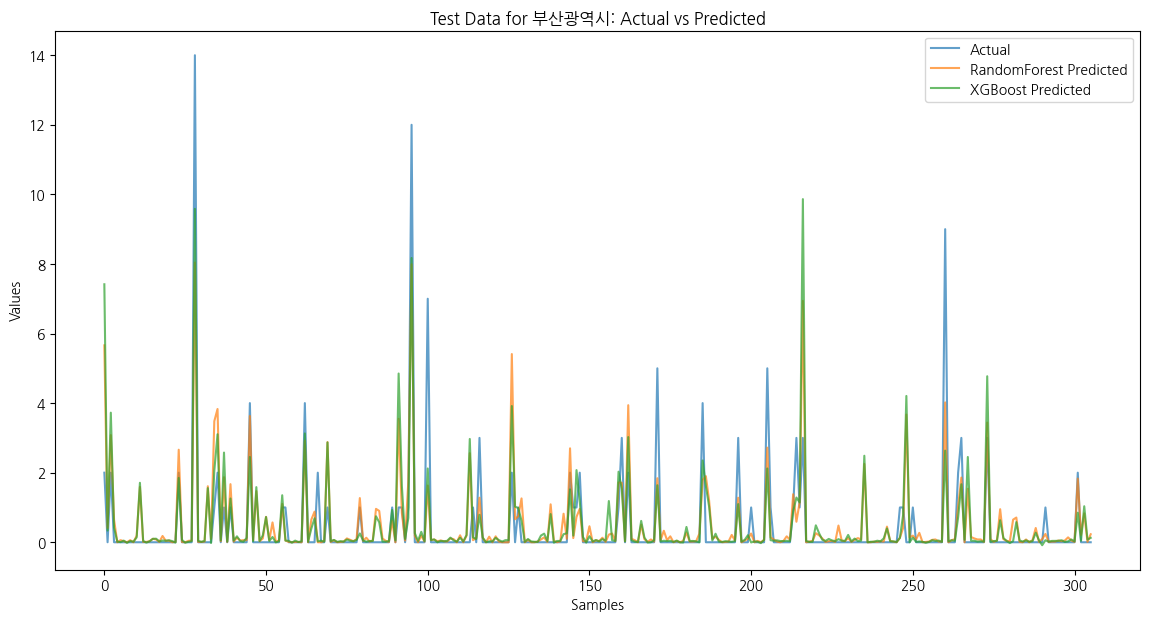

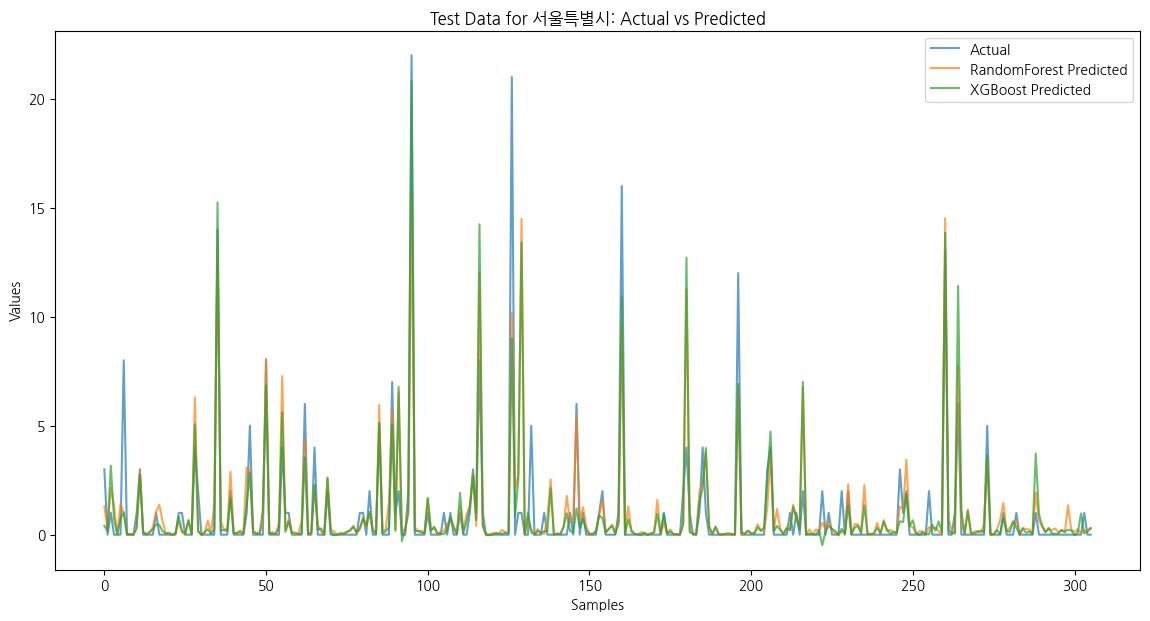

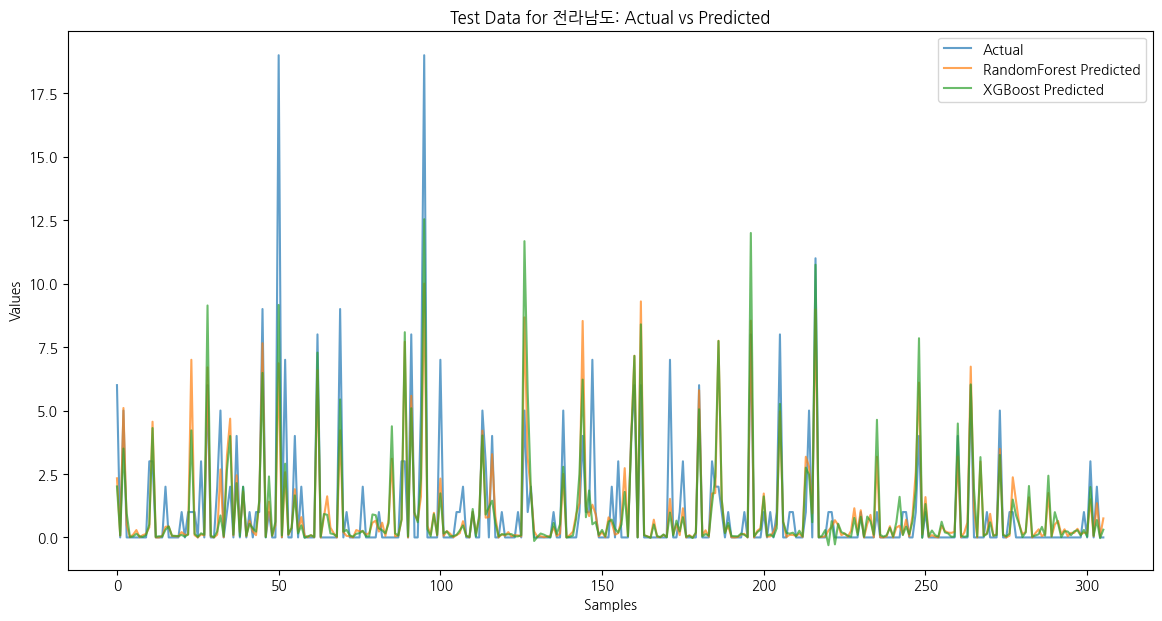

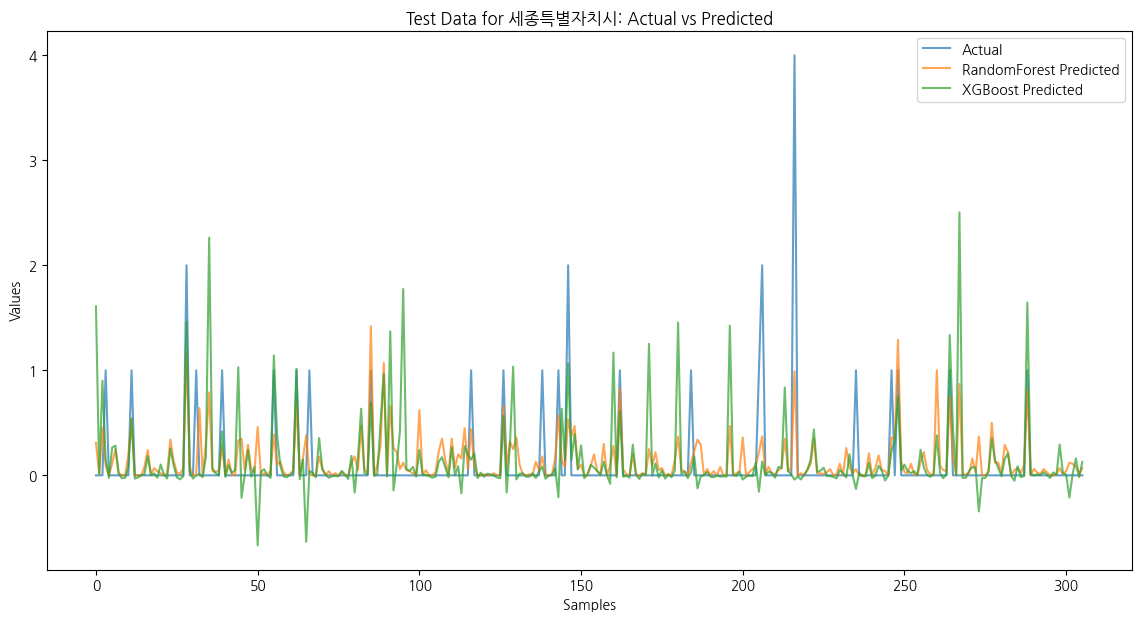

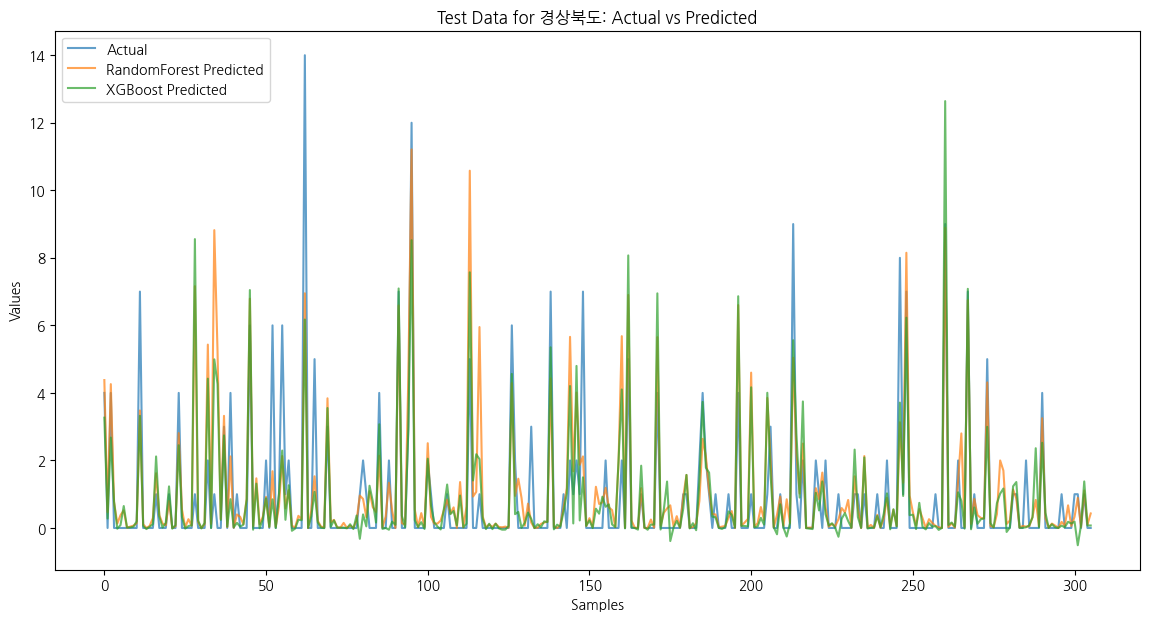

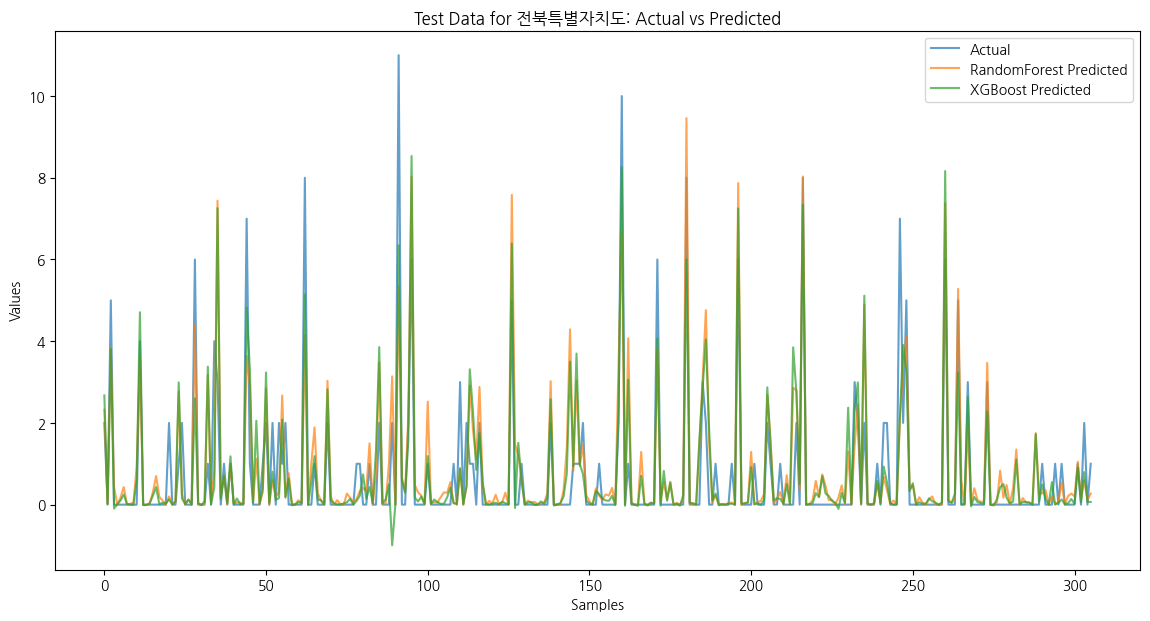

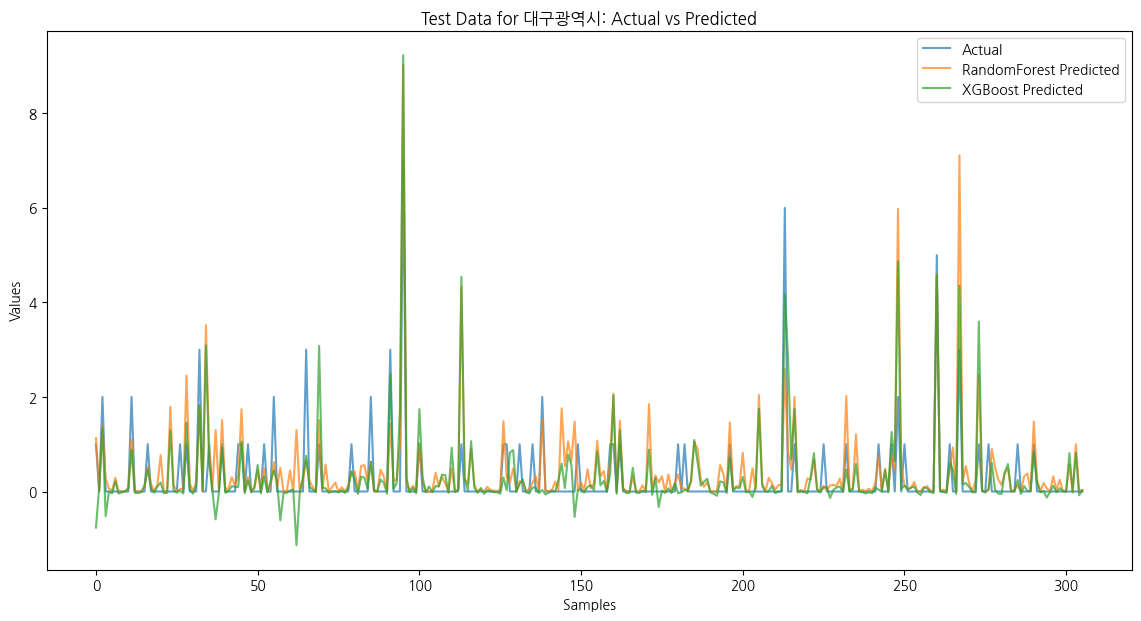

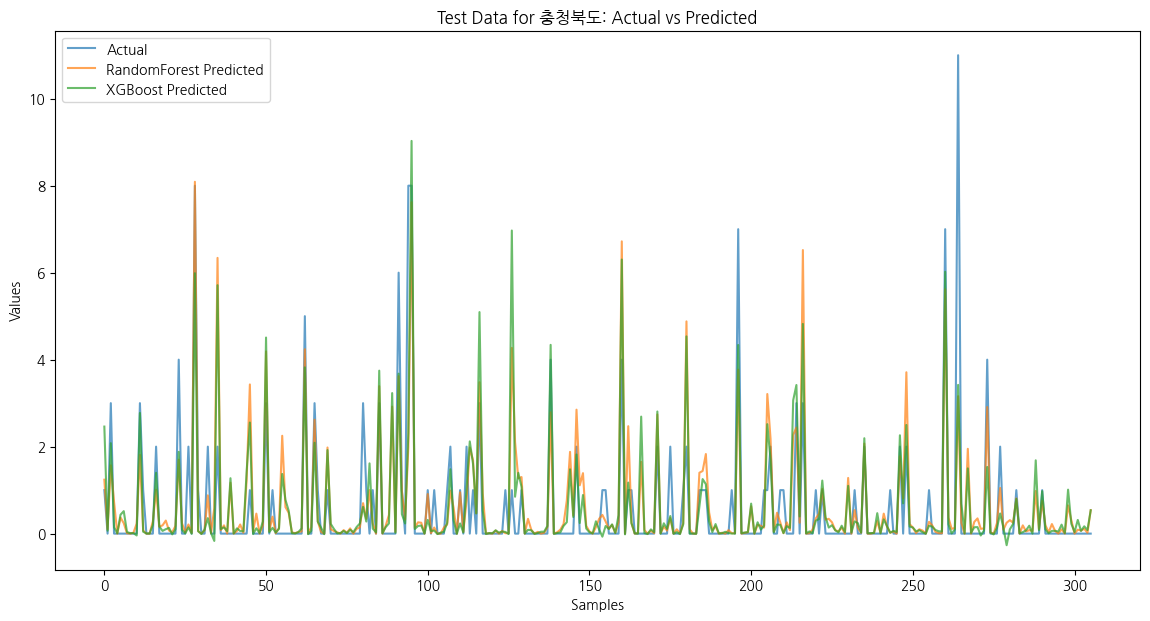

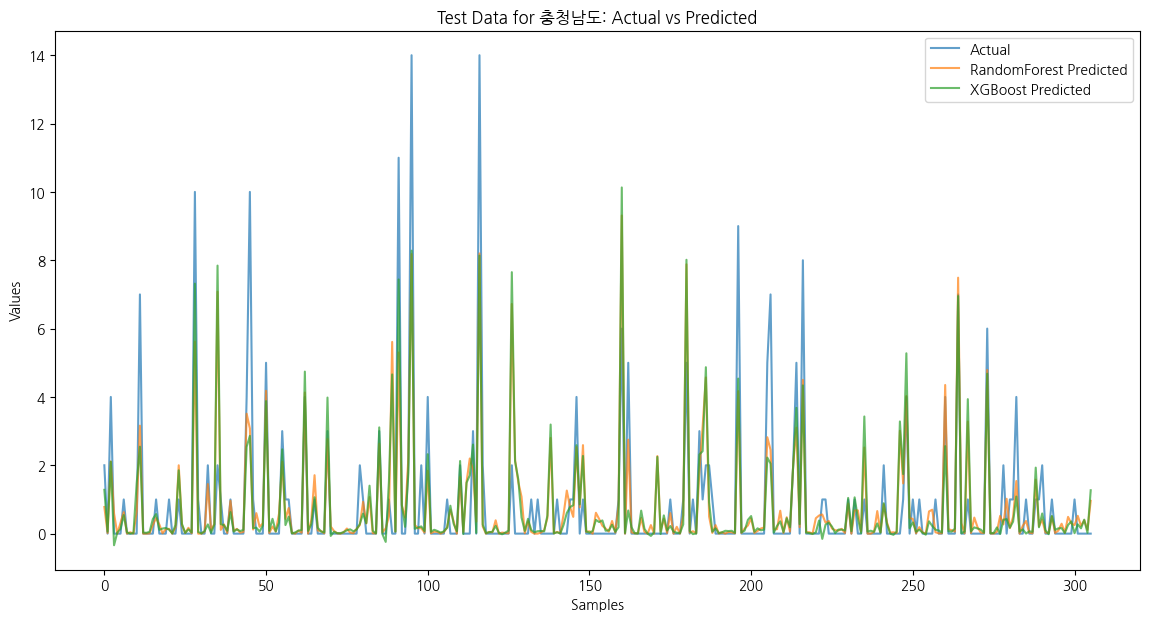


Model: RandomForest
경기도 - MSE: 5.491804575163399, MAE: 1.1523529411764706, R^2: 0.7912287122598938
인천광역시 - MSE: 0.9508718954248367, MAE: 0.39705882352941174, R^2: 0.5340194230447162
경상남도 - MSE: 2.126823202614379, MAE: 0.7368954248366013, R^2: 0.6169369194104035
울산광역시 - MSE: 0.3545450980392157, MAE: 0.2826143790849673, R^2: 0.28748557079389614
광주광역시 - MSE: 0.5894522875816992, MAE: 0.36568627450980395, R^2: 0.4165605606706061
대전광역시 - MSE: 0.32449901960784316, MAE: 0.3072875816993464, R^2: -0.010804730538922058
강원특별자치도 - MSE: 0.7545669934640523, MAE: 0.49062091503267974, R^2: 0.3554585385878489
제주특별자치도 - MSE: 1.2365042483660131, MAE: 0.5011437908496733, R^2: 0.3100698872574724
부산광역시 - MSE: 0.9013565359477125, MAE: 0.40669934640522876, R^2: 0.5709951019910233
서울특별시 - MSE: 2.437638888888889, MAE: 0.6627124183006535, R^2: 0.6501689682126107
전라남도 - MSE: 2.4179264705882355, MAE: 0.7719934640522876, R^2: 0.5919609361623901
세종특별자치시 - MSE: 0.10996895424836602, MAE: 0.1588562091503268, R^2: 0.253

In [10]:
# 시도별 성능 저장 딕셔너리
sido_metrics = {'RandomForest': {}, 'XGBoost': {}}

# 시도별로 실제값과 예측값을 비교하여 MSE, MAE, R^2 계산
for sido_cd in sido_cds:
    df_test_sido = test_data[test_data['sido_cd'] == sido_cd]
    X_test_sido = df_test_sido[features]
    y_test_sido = df_test_sido[target]

    # 데이터 스케일링
    X_test_sido = scaler.transform(X_test_sido)

    # RandomForest 예측
    y_pred_test_rf = rf_model.predict(X_test_sido)

    # XGBoost 예측
    y_pred_test_xgb = xgb_model.predict(X_test_sido)

    # 성능 평가 (RandomForest)
    mse_rf = mean_squared_error(y_test_sido, y_pred_test_rf)
    mae_rf = mean_absolute_error(y_test_sido, y_pred_test_rf)
    r2_rf = r2_score(y_test_sido, y_pred_test_rf)

    sido_metrics['RandomForest'][sido_cd] = {'mse': mse_rf, 'mae': mae_rf, 'r2': r2_rf}

    # 성능 평가 (XGBoost)
    mse_xgb = mean_squared_error(y_test_sido, y_pred_test_xgb)
    mae_xgb = mean_absolute_error(y_test_sido, y_pred_test_xgb)
    r2_xgb = r2_score(y_test_sido, y_pred_test_xgb)

    sido_metrics['XGBoost'][sido_cd] = {'mse': mse_xgb, 'mae': mae_xgb, 'r2': r2_xgb}

    # 시각화
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_sido.reset_index(drop=True), label='Actual', alpha=0.7)
    plt.plot(y_pred_test_rf, label='RandomForest Predicted', alpha=0.7)
    plt.plot(y_pred_test_xgb, label='XGBoost Predicted', alpha=0.7)
    title = dt_map.get(str(sido_cd), f'Sido_cd {sido_cd}')
    plt.title(f'Test Data for {title}: Actual vs Predicted')
    plt.xlabel('Samples')
    plt.ylabel('Values')
    # plt.savefig(f'{sido_cd}_actual_predict_rf_xgb')
    plt.legend()
    plt.show()

# 시도별 성능 지표 출력
for model_name, metrics_dict in sido_metrics.items():
    print(f"\nModel: {model_name}")
    for sido_cd, metrics in metrics_dict.items():
        title = dt_map.get(str(sido_cd), f'Sido_cd {sido_cd}')
        print(f"{title} - MSE: {metrics['mse']}, MAE: {metrics['mae']}, R^2: {metrics['r2']}")

In [12]:
# 성능 지표를 저장할 리스트 초기화
metrics_list = []

# 시도별 성능 지표 저장
for model_name, metrics_dict in sido_metrics.items():
    for sido_cd, metrics in metrics_dict.items():
        title = dt_map.get(str(sido_cd), f'Sido_cd {sido_cd}')
        metrics_list.append({
            'Model': model_name,
            'sido_name': title,
            'sido_cd': sido_cd,
            'MSE': metrics['mse'],
            'MAE': metrics['mae'],
            'R2': metrics['r2']
        })

# 리스트를 데이터프레임으로 변환
df_metrics = pd.DataFrame(metrics_list)

df_metrics.to_csv('sido_metrics2.csv', encoding='utf-8-sig', index=False)

### SIDO별 모델링(CASE2)

In [4]:
# 데이터 불러오기
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0731.csv'
df = pd.read_csv(path)

In [5]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [6]:
features = ['weekend_yn', 'sido_cd', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
            'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
            'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
            'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
            'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target = 'patientsCnt'

In [7]:
df_sido_11_test=df[df['sido_cd']==11].sample(frac=0.2, random_state=11)

In [8]:
df_train = df[~df.index.isin(df_sido_11_test.index)]
df_test = df_sido_11_test

# 특징과 목표 변수 분리
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

# 데이터 스케일링
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### RandomForest

#### grid search 적용

In [9]:
# RandomForest 모델 정의 및 학습
rf_model = RandomForestRegressor(random_state=11)
rf_model.fit(X_train, y_train)

# 예측
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# 평가
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
r2_train_rf = r2_score(y_train, y_pred_train_rf)

mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
r2_test_rf = r2_score(y_test, y_pred_test_rf)

print("Random Forest Regressor:")
print(f'Training MAE: {mae_train_rf}')
print(f'Training RMSE: {rmse_train_rf}')
print(f'Training R2: {r2_train_rf}')
print()
print(f'Test MAE: {mae_test_rf}')
print(f'Test RMSE: {rmse_test_rf}')
print(f'Test R2: {r2_test_rf}')

Random Forest Regressor:
Training MAE: 0.19413865546218492
Training RMSE: 0.4671681729035519
Training R2: 0.9609170674611934

Test MAE: 0.6561764705882351
Test RMSE: 1.5359224730230543
Test R2: 0.6614463105784263


### XGBoost

In [11]:
# XGBoost 모델 정의 및 학습
xgb_model = XGBRegressor(random_state=11)
xgb_model.fit(X_train, y_train)

# 예측
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

# 평가
mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)

mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
r2_test_xgb = r2_score(y_test, y_pred_test_xgb)

print("XGBoost Regressor:")
print(f'Training MAE: {mae_train_xgb}')
print(f'Training RMSE: {rmse_train_xgb}')
print(f'Training R2: {r2_train_xgb}')
print()
print(f'Test MAE: {mae_test_xgb}')
print(f'Test RMSE: {rmse_test_xgb}')
print(f'Test R2: {r2_test_xgb}')

XGBoost Regressor:
Training MAE: 0.27232090261121206
Training RMSE: 0.5111212449092686
Training R2: 0.9532169519869655

Test MAE: 0.6442529644369713
Test RMSE: 1.5976208749296086
Test R2: 0.6337004254888027
